## SEGMENTACION UNET VS SAMGEO

El objetivo de este ejercicio es comparar segmentación semántica de Unet con Samgeo, a partir de un dataset de cuerpos de agua en imágenes Sentinel-2 (RGB).

Fuente del dataset: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies



In [1]:
# estandar
import os
import cv2 as cv
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm

# data
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt
from PIL import Image

# modelo
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

Esta función nos va a ayudar a mostrar las imágenes.

In [2]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')


In [3]:
import zipfile

# Crear el directorio 'data' si no existe
os.makedirs('data', exist_ok=True)

# Ruta del archivo zip en tu máquina local
zip_file_path = r'C:\Users\JUANC\Cursos\IA AMBIENTAL\TF\archive.zip'

# Descomprimir el archivo zip en el directorio 'data'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('data')


In [4]:
from itertools import islice

# Ruta al directorio
directory_path = r'C:\Users\JUANC\Cursos\IA AMBIENTAL\TF\data\Water Bodies Dataset'

# Listar archivos en el directorio
files = os.listdir(directory_path)

# Mostrar los primeros 20 archivos
for file_name in islice(files, 20):
    print(file_name)


Images
Masks


In [5]:
import os
images = []
mask = []

image_path = r'C:\Users\JUANC\Cursos\IA AMBIENTAL\TF\data\Water Bodies Dataset/Images/'
mask_path = r'C:\Users\JUANC\Cursos\IA AMBIENTAL\TF\data\Water Bodies Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Imagenes y máscaras correctamente localizadas')

Imagenes y máscaras correctamente localizadas


In [6]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')
  mask = mask/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:37<00:00, 76.35it/s] 


Vemos un ejemplo del conjunto de imágenes.

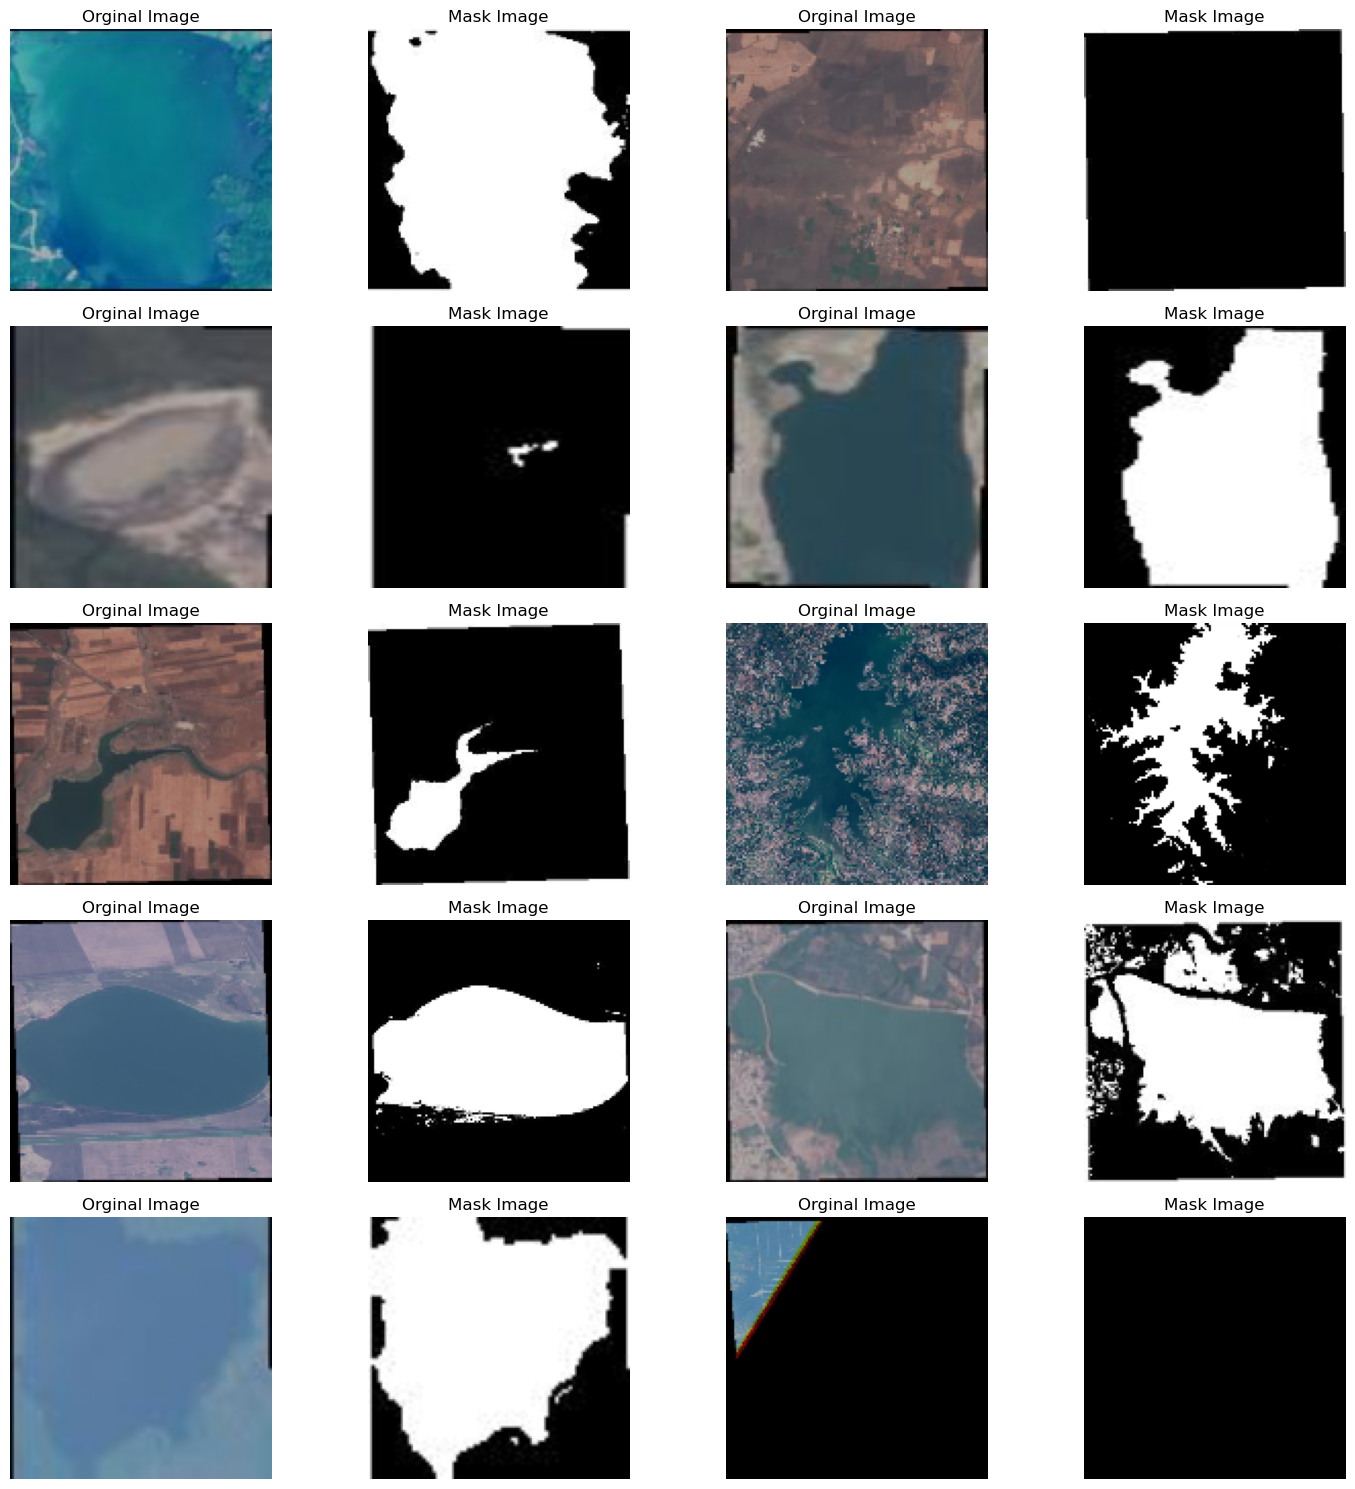

In [7]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **U-Net**

Separar el dataset en entrenamiento y predicción.

Asignar de esta manera:

* X_train, y_train: 70% de los datos

* X_val, y_val: 20%

* X_test, y_test: 10%

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Definir las proporciones
train_size = 0.7
val_size = 0.2
test_size = 0.1

# Dividir el dataset en entrenamiento+resto y prueba
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=(1 - train_size), random_state=42)

# Ahora dividir el resto (X_temp, y_temp) en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (val_size + test_size)), random_state=42)

# Imprimir la cantidad de datos en cada conjunto
print(f"Total de datos: {len(images)}")
print(f"Conjunto de entrenamiento: {len(X_train)}")
print(f"Conjunto de validación: {len(X_val)}")
print(f"Conjunto de prueba: {len(X_test)}")

Total de datos: 2841
Conjunto de entrenamiento: 1988
Conjunto de validación: 568
Conjunto de prueba: 285


In [9]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1988, 128, 128, 3) (1988, 128, 128, 1)
(568, 128, 128, 3) (568, 128, 128, 1)
(285, 128, 128, 3) (285, 128, 128, 1)


Creación de una función llamada `unet` que recibe parametros de entrada el tamaño de las imagenes de entrada (una tupla) y la cantidad de clase a predecir.


In [10]:
# definir funcion
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


def unet(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Capa de entrada
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Contracción
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Fondo
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Expansión con Conv2DTranspose
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3)
    up1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv4)
    up2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    # Capa de salida
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    conv6 = Conv2D(num_classes, (1, 1), activation=activation)(conv5)

    model = Model(inputs=[inputs], outputs=[conv6])

    return model

In [11]:
print(X_train.shape)  #  Input para entrenamiento
print(X_val.shape)   # Input para validación

(1988, 128, 128, 3)
(568, 128, 128, 3)


In [12]:
from tensorflow.keras import backend as K
def iou_coeff(y_true, y_pred):
    # Calcula la intersección entre el y_true y y_pred
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    # Calcula la unión
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    # Calcula el coeficiente de IoU
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_accuracy
# Compilar el modelo
unet = unet(input_size=(128, 128, 3))
unet.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=[binary_accuracy, iou_coeff]
)



Agregamos una clase para mostrar visualmente el progreso cuando entrenamos la red. Vamos a ver esto reflejado en los Callbacks.

In [14]:
# Callback

from tensorflow.keras.callbacks import Callback

class ShowProgress(Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')

    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()
# Post Process
def post_process(image,threshold=0.4):
  return image>threshold


In [15]:
callbacks_list = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.keras',save_best_only=True),
    ShowProgress(save=True)
]

Veamos cómo quedó la red.

In [16]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

Ejercicio 5:

Entrenar la red, con un batch_size de 16, 30 epochs y usando X_val e y_val como datos de validación.

Epoch 1/30
1/1 [==============================] - 0s 347ms/step loss: 0.5438 - binary_accuracy: 0.6015 - iou_coeff: 0.15


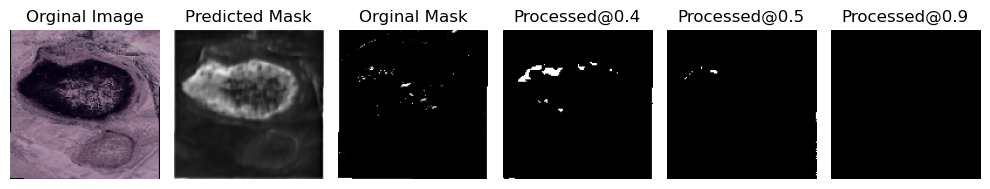

125/125 [==============================] - 18s 59ms/step - loss: 0.5438 - binary_accuracy: 0.6015 - iou_coeff: 0.1530 - val_loss: 0.4640 - val_binary_accuracy: 0.6485 - val_iou_coeff: 0.1639
Epoch 2/30
1/1 [==============================] - 0s 17ms/step- loss: 0.4613 - binary_accuracy: 0.6465 - iou_coeff: 0.18


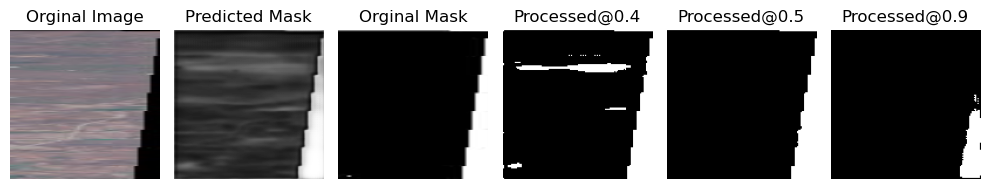

125/125 [==============================] - 6s 44ms/step - loss: 0.4613 - binary_accuracy: 0.6465 - iou_coeff: 0.1872 - val_loss: 0.4610 - val_binary_accuracy: 0.6550 - val_iou_coeff: 0.2004
Epoch 3/30
1/1 [==============================] - 0s 16ms/step- loss: 0.4265 - binary_accuracy: 0.6645 - iou_coeff: 0.20


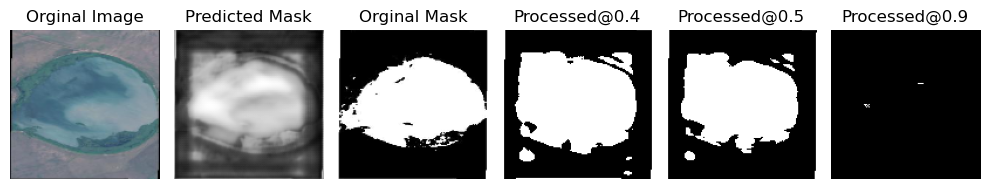

125/125 [==============================] - 6s 45ms/step - loss: 0.4263 - binary_accuracy: 0.6645 - iou_coeff: 0.2016 - val_loss: 0.4046 - val_binary_accuracy: 0.6816 - val_iou_coeff: 0.2069
Epoch 4/30
1/1 [==============================] - 0s 17ms/step- loss: 0.3974 - binary_accuracy: 0.6783 - iou_coeff: 0.21


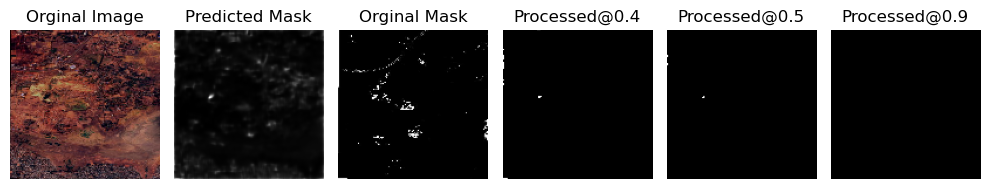

125/125 [==============================] - 6s 44ms/step - loss: 0.3974 - binary_accuracy: 0.6783 - iou_coeff: 0.2102 - val_loss: 0.3835 - val_binary_accuracy: 0.6815 - val_iou_coeff: 0.2130
Epoch 5/30
1/1 [==============================] - 0s 14ms/step- loss: 0.3694 - binary_accuracy: 0.6886 - iou_coeff: 0.22


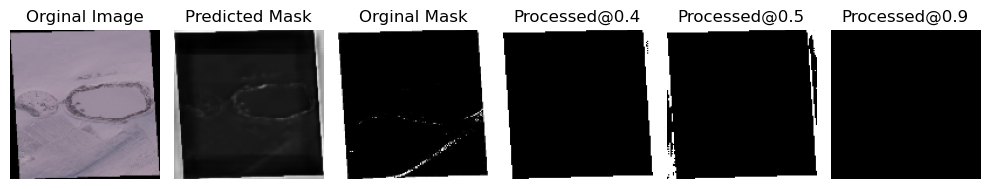

125/125 [==============================] - 6s 44ms/step - loss: 0.3695 - binary_accuracy: 0.6891 - iou_coeff: 0.2209 - val_loss: 0.3735 - val_binary_accuracy: 0.6913 - val_iou_coeff: 0.1855
Epoch 6/30
1/1 [==============================] - 0s 24ms/step- loss: 0.3550 - binary_accuracy: 0.6952 - iou_coeff: 0.22


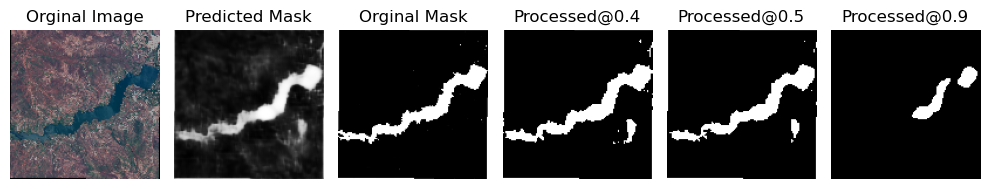

125/125 [==============================] - 6s 45ms/step - loss: 0.3550 - binary_accuracy: 0.6951 - iou_coeff: 0.2247 - val_loss: 0.3804 - val_binary_accuracy: 0.6905 - val_iou_coeff: 0.2446
Epoch 7/30
1/1 [==============================] - 0s 15ms/step- loss: 0.3417 - binary_accuracy: 0.7005 - iou_coeff: 0.23


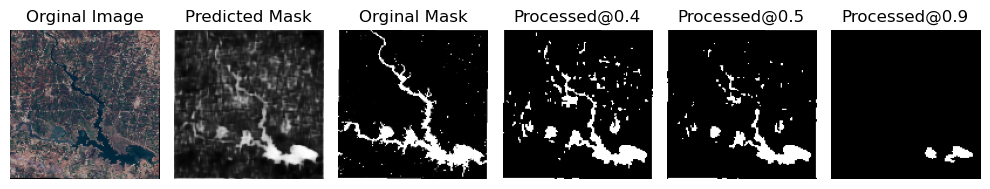

125/125 [==============================] - 6s 45ms/step - loss: 0.3414 - binary_accuracy: 0.7006 - iou_coeff: 0.2315 - val_loss: 0.3330 - val_binary_accuracy: 0.7043 - val_iou_coeff: 0.2348
Epoch 8/30
1/1 [==============================] - 0s 19ms/step- loss: 0.3398 - binary_accuracy: 0.7006 - iou_coeff: 0.23


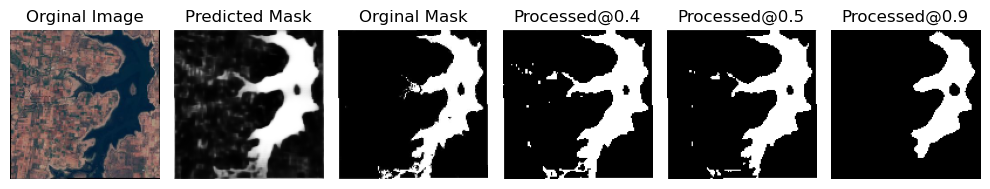

125/125 [==============================] - 6s 44ms/step - loss: 0.3400 - binary_accuracy: 0.7005 - iou_coeff: 0.2318 - val_loss: 0.3338 - val_binary_accuracy: 0.7030 - val_iou_coeff: 0.2358
Epoch 9/30
1/1 [==============================] - 0s 17ms/step- loss: 0.3293 - binary_accuracy: 0.7050 - iou_coeff: 0.23


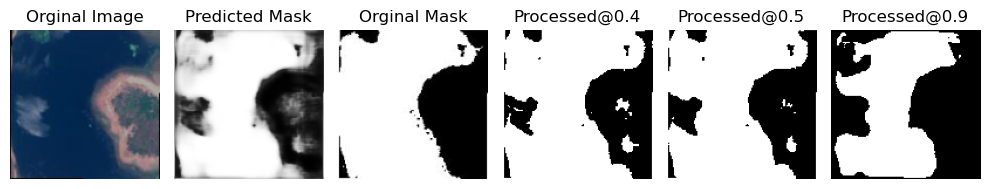

125/125 [==============================] - 6s 45ms/step - loss: 0.3292 - binary_accuracy: 0.7051 - iou_coeff: 0.2348 - val_loss: 0.3241 - val_binary_accuracy: 0.7039 - val_iou_coeff: 0.2417
Epoch 10/30
1/1 [==============================] - 0s 15ms/step- loss: 0.3278 - binary_accuracy: 0.7064 - iou_coeff: 0.23


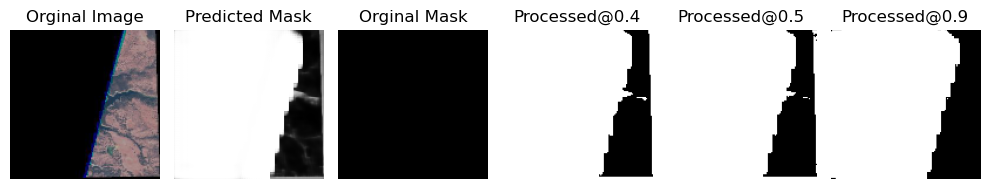

125/125 [==============================] - 6s 45ms/step - loss: 0.3277 - binary_accuracy: 0.7065 - iou_coeff: 0.2357 - val_loss: 0.3156 - val_binary_accuracy: 0.7136 - val_iou_coeff: 0.2213
Epoch 11/30
1/1 [==============================] - 0s 6ms/step - loss: 0.3195 - binary_accuracy: 0.7089 - iou_coeff: 0.23


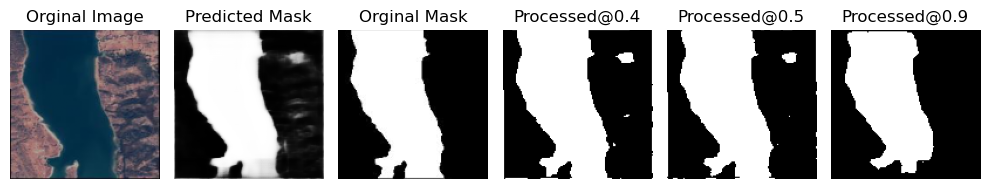

125/125 [==============================] - 6s 44ms/step - loss: 0.3196 - binary_accuracy: 0.7087 - iou_coeff: 0.2389 - val_loss: 0.3215 - val_binary_accuracy: 0.7134 - val_iou_coeff: 0.2166
Epoch 12/30
1/1 [==============================] - 0s 16ms/step- loss: 0.3116 - binary_accuracy: 0.7124 - iou_coeff: 0.23


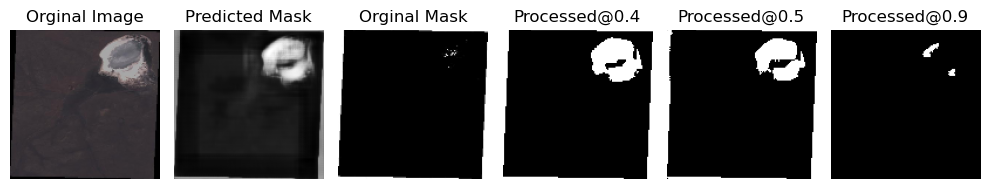

125/125 [==============================] - 6s 44ms/step - loss: 0.3126 - binary_accuracy: 0.7125 - iou_coeff: 0.2399 - val_loss: 0.3203 - val_binary_accuracy: 0.7068 - val_iou_coeff: 0.2509
Epoch 13/30
1/1 [==============================] - 0s 18ms/step- loss: 0.3048 - binary_accuracy: 0.7136 - iou_coeff: 0.24


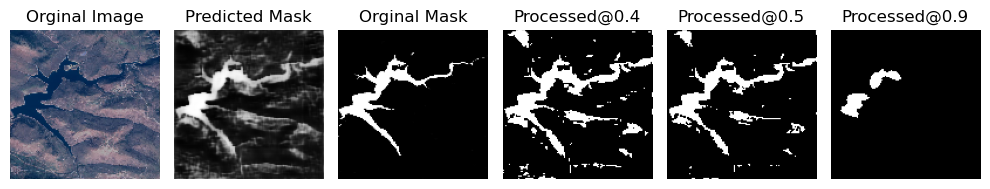

125/125 [==============================] - 6s 47ms/step - loss: 0.3048 - binary_accuracy: 0.7136 - iou_coeff: 0.2434 - val_loss: 0.3215 - val_binary_accuracy: 0.7083 - val_iou_coeff: 0.2386


In [17]:
# Entrenar el modelo
num_epochs = 30
history = unet.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=callbacks_list)

Visualizacion al azar de la predicción del modelo y la máscara de verdad de campo asociada, a fines de evaluar cualitativamente el modelo.

1/1 [==============================] - 0s 33ms/step


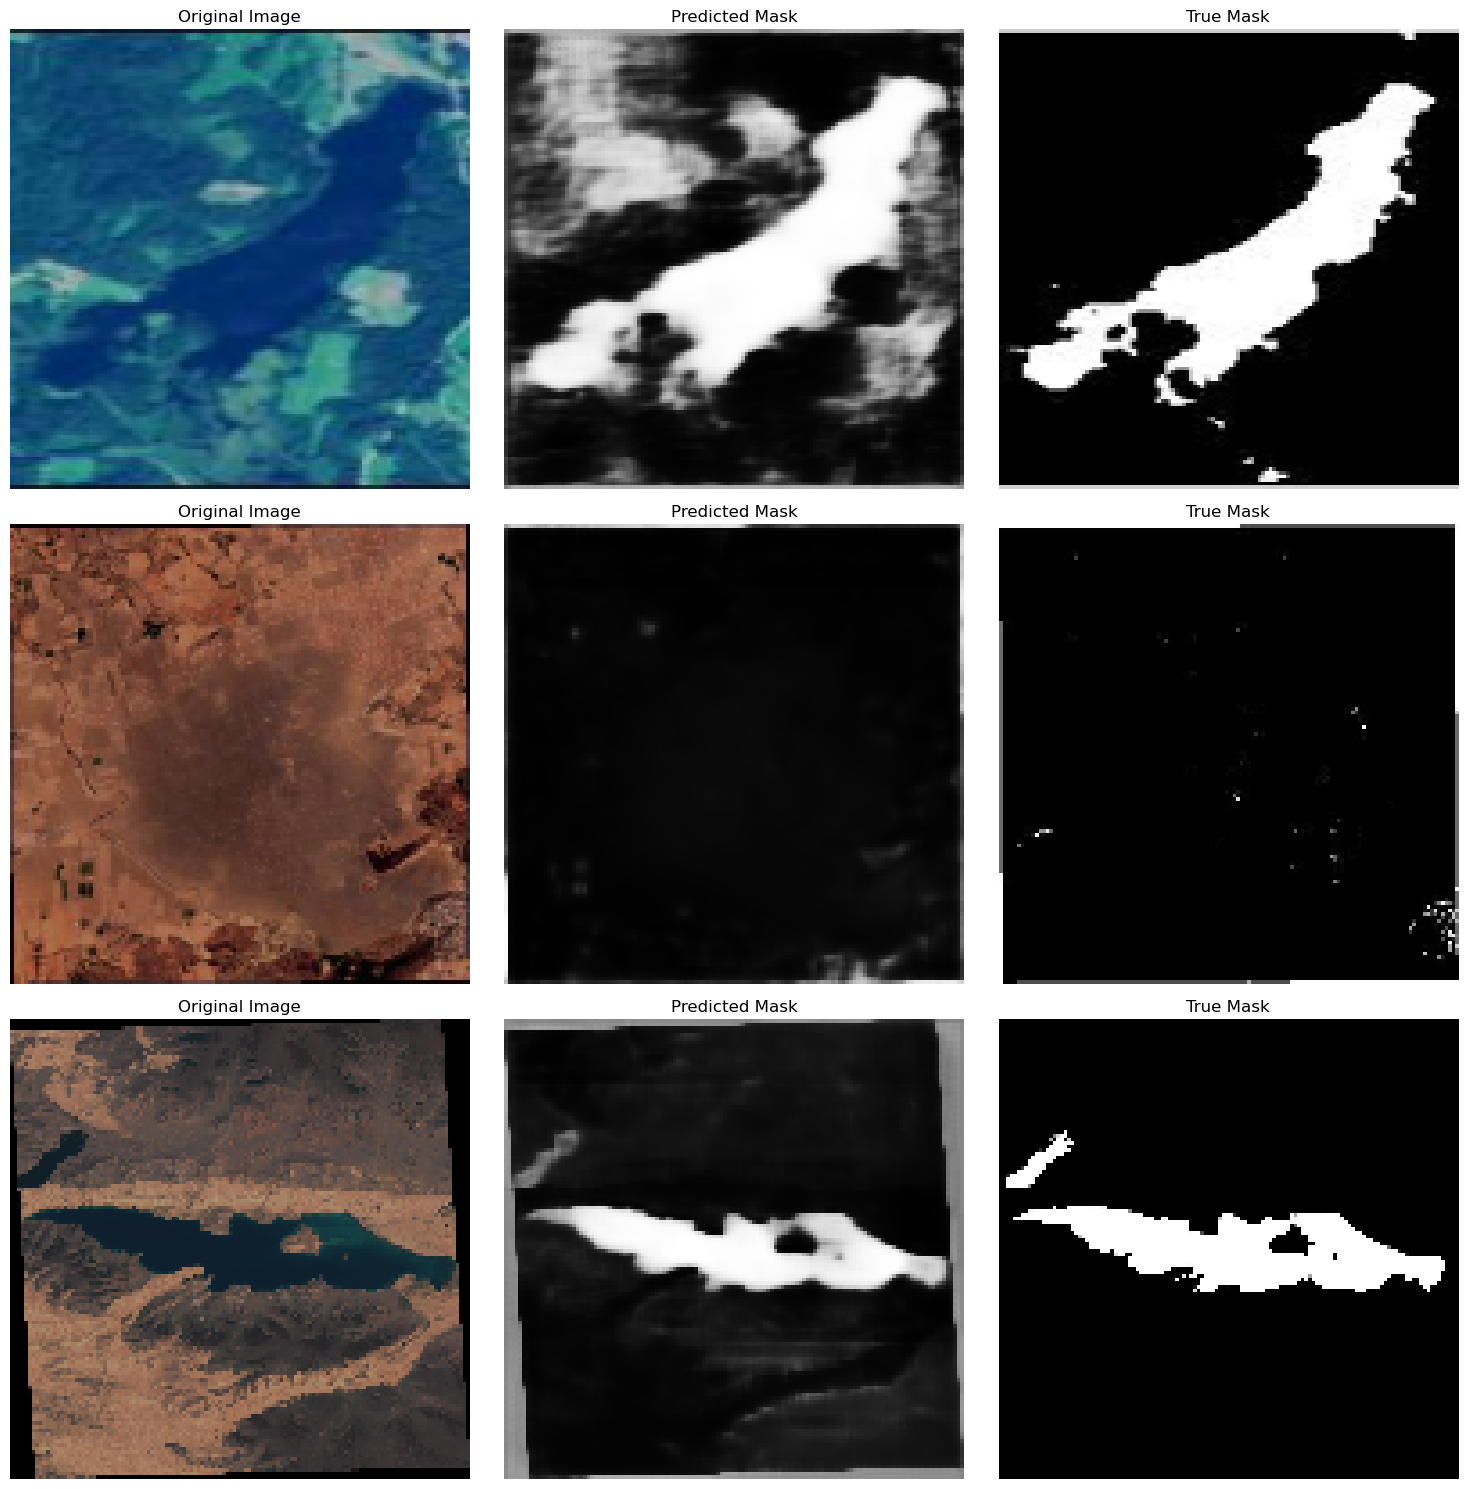

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Función para imprimir tres ejemplos aleatorios
def print_random_examples(model, images, masks, num_examples=3):
    # Seleccionar num_examples imágenes aleatorias
    random_indices = np.random.choice(len(images), num_examples, replace=False)

    plt.figure(figsize=(15, 5 * num_examples))

    for i, idx in enumerate(random_indices):
        real_img = images[idx][np.newaxis, ...]
        pred_mask = model.predict(real_img).reshape(128, 128)
        true_mask = masks[idx].reshape(128, 128)

        # Mostrar la imagen original
        plt.subplot(num_examples, 3, 3 * i + 1)
        show_image(real_img[0], title="Original Image")

        # Mostrar la máscara predicha
        plt.subplot(num_examples, 3, 3 * i + 2)
        show_image(pred_mask, title="Predicted Mask", cmap='gray')

        # Mostrar la máscara verdadera
        plt.subplot(num_examples, 3, 3 * i + 3)
        show_image(true_mask, title="True Mask", cmap='gray')

    plt.tight_layout()
    plt.show()

# Llamar a la función para imprimir tres ejemplos aleatorios
print_random_examples(unet, X_val, y_val)


Ejercicio 7:

Evaluacion y Validacion del modelo con el conjunto de datos de test (X_test) y (y_test) aplicando la métrica IoU.

In [19]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import tensorflow as tf

# Load the trained model
unet_loaded = load_model('UNet-01.keras', custom_objects={'iou_coeff': iou_coeff})

# Define the IoU calculation function
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.float32)
    true_mask_tensor = K.constant(true_mask)
    pred_mask_tensor = K.constant(pred_mask)
    iou_value = K.get_value(iou_coeff(true_mask_tensor, pred_mask_tensor))
    return np.mean(iou_value).item() if isinstance(iou_value, np.ndarray) else iou_value.item()

# Define the prediction function outside the loop to avoid retracing
predict_fn = tf.function(unet_loaded.predict)

# Evaluate the model on the test set
def evaluate_model(model, X_test, y_test, threshold=0.5):
    iou_scores = []
    for i in range(len(X_test)):
        pred_mask = model.predict(X_test[i][np.newaxis, ...])[0]
        true_mask = y_test[i]
        iou_score = calculate_iou(pred_mask, true_mask, threshold)
        iou_scores.append(iou_score)
        print(f'IoU for image {i+1}: {iou_score:.4f}')
    average_iou = np.mean(iou_scores)
    return average_iou, iou_scores

# Apply the model to the test set and calculate IoU
average_iou, test_iou_scores = evaluate_model(unet_loaded, X_test, y_test)
print(f'Average IoU on the test set: {average_iou:.4f}')


1/1 [==============================] - 0s 103ms/step
IoU for image 1: 0.9374
1/1 [==============================] - 0s 16ms/step
IoU for image 2: 0.9288
1/1 [==============================] - 0s 16ms/step
IoU for image 3: 0.8812
1/1 [==============================] - 0s 16ms/step
IoU for image 4: 0.8396
1/1 [==============================] - 0s 15ms/step
IoU for image 5: 0.8779
1/1 [==============================] - 0s 24ms/step
IoU for image 6: 0.8393
1/1 [==============================] - 0s 16ms/step
IoU for image 7: 0.7650
1/1 [==============================] - 0s 16ms/step
IoU for image 8: 0.7091
1/1 [==============================] - 0s 22ms/step
IoU for image 9: 0.9417
1/1 [==============================] - 0s 31ms/step
IoU for image 10: 0.8665
1/1 [==============================] - 0s 14ms/step
IoU for image 11: 0.5895
1/1 [==============================] - 0s 20ms/step
IoU for image 12: 0.8074
1/1 [==============================] - 0s 15ms/step
IoU for image 13: 0.6587
1/1 [==

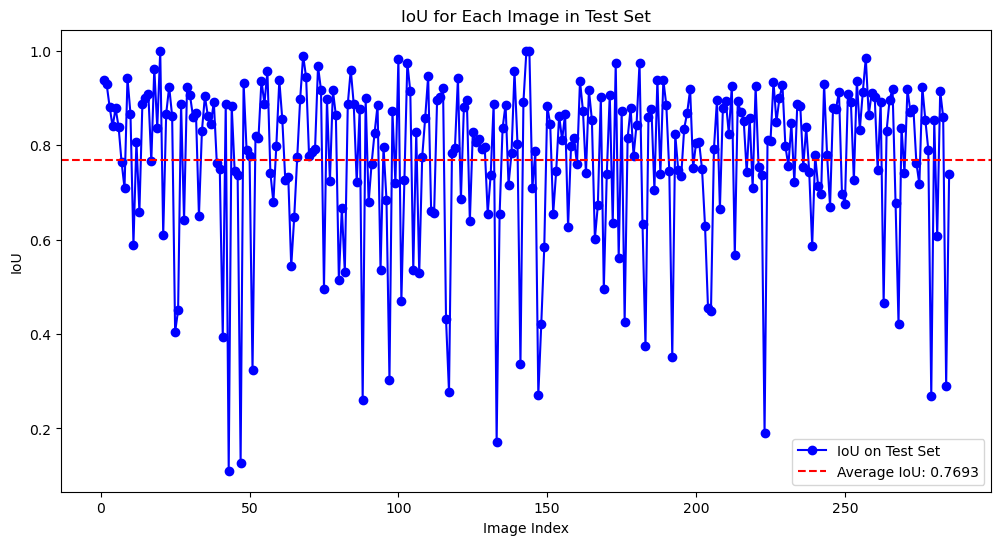

In [20]:
# Graficar IoU de cada imagen en el conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(test_iou_scores) + 1), test_iou_scores, 'bo-', label='IoU on Test Set')
plt.axhline(y=average_iou, color='r', linestyle='--', label=f'Average IoU: {average_iou:.4f}')
plt.title('IoU for Each Image in Test Set')
plt.xlabel('Image Index')
plt.ylabel('IoU')
plt.legend()
plt.show()

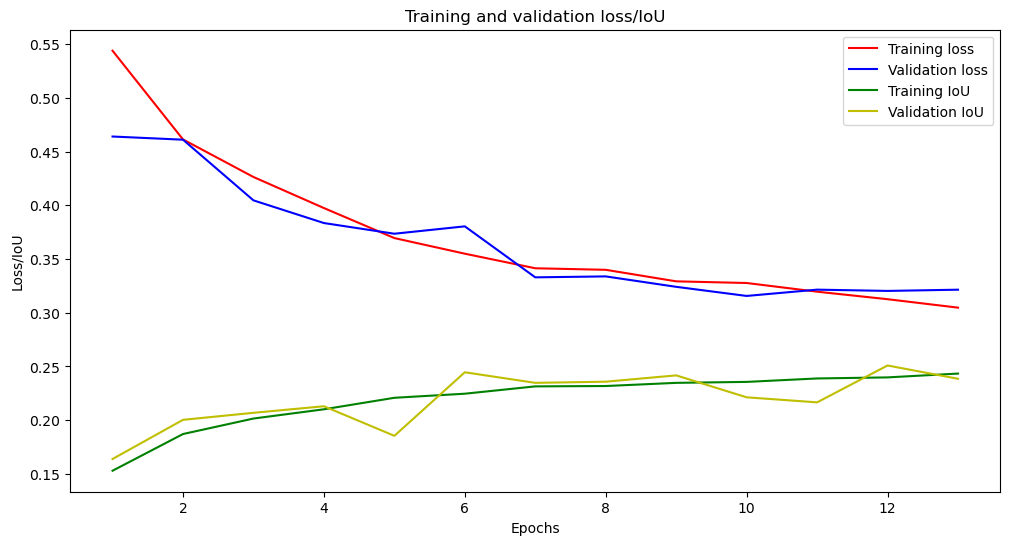

In [21]:
# Extract metrics from history
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_ious = history.history['iou_coeff']
val_ious = history.history['val_iou_coeff']

# Asegurarse de que todas las listas tengan la misma longitud
min_length = min(len(train_losses), len(val_losses), len(train_ious), len(val_ious))
train_losses = train_losses[:min_length]
val_losses = val_losses[:min_length]
train_ious = train_ious[:min_length]
val_ious = val_ious[:min_length]
epochs = range(1, min_length + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, 'r', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='Validation loss')
plt.plot(epochs, train_ious, 'g', label='Training IoU')
plt.plot(epochs, val_ious, 'y', label='Validation IoU')
plt.title('Training and validation loss/IoU')
plt.xlabel('Epochs')
plt.ylabel('Loss/IoU')
plt.legend()
plt.show()

In [23]:
#Guardando datos de prueba en archivo npy para la segmentacion con samgeo en el notebook SAM_Generacion_mask
np.save('x_test.npy', X_test)

In [27]:
# Funcion para evaluar directamente las máscaras generadas por SAMGEO
def evaluate_segmented_masks(segmented_masks, y_test, threshold=0.5):
    iou_scores = []
    for i in range(len(segmented_masks)):
        segmented_mask = segmented_masks[i]
        true_mask = y_test[i]
        iou_score = calculate_iou(segmented_mask, true_mask, threshold)
        iou_scores.append(iou_score)
        print(f'IoU for segmented mask {i+1}: {iou_score:.4f}')
    average_iou = np.mean(iou_scores)
    return average_iou, iou_scores

## Cargar las marcaras segmentadas generadas por Samgeo en el notebook "SAM_Generacion_mask"

In [25]:
import numpy as np
import os

# # Directorio donde se guardaron las máscaras segmentadas
segmented_masks_dir = 'segmented_masks'

# # Lista para almacenar las máscaras cargadas
loaded_segmented_masks = []

# # Cargar cada máscara guardada
for i in range(len(X_test)):  # Asegúrate de que el número de archivos coincida con el número de imágenes en X_test
     mask = np.load(os.path.join(segmented_masks_dir, f'segmented_mask_{i}.npy'))
     loaded_segmented_masks.append(mask)

# # Convertir la lista a un array de numpy
segmented_masks = np.array(loaded_segmented_masks)

In [28]:
# Verificar formas de los datos
print(f'Forma de X_test: {X_test.shape}')
print(f'Forma de y_test: {y_test.shape}')
print(f'Forma de segmented_masks: {segmented_masks.shape}')

# Evaluar las máscaras segmentadas con metrica IoU
average_iou_segmented, segmented_iou_scores = evaluate_segmented_masks(segmented_masks, y_test)
print(f'Average IoU on the segmented masks: {average_iou_segmented:.4f}')


Forma de X_test: (285, 128, 128, 3)
Forma de y_test: (285, 128, 128, 1)
Forma de segmented_masks: (285, 128, 128, 3)
IoU for segmented mask 1: 0.3995
IoU for segmented mask 2: 0.2816
IoU for segmented mask 3: 0.0765
IoU for segmented mask 4: 0.2603
IoU for segmented mask 5: 0.4773
IoU for segmented mask 6: 0.6730
IoU for segmented mask 7: 1.0011
IoU for segmented mask 8: 1.5252
IoU for segmented mask 9: 0.8873
IoU for segmented mask 10: 0.5939
IoU for segmented mask 11: 0.7335
IoU for segmented mask 12: 1.9107
IoU for segmented mask 13: 0.8686
IoU for segmented mask 14: 1.0940
IoU for segmented mask 15: 0.0579
IoU for segmented mask 16: 2.2295
IoU for segmented mask 17: 0.8486
IoU for segmented mask 18: 0.0553
IoU for segmented mask 19: 0.8388
IoU for segmented mask 20: 3.0000
IoU for segmented mask 21: 0.3297
IoU for segmented mask 22: 0.0454
IoU for segmented mask 23: 1.2245
IoU for segmented mask 24: 0.0363
IoU for segmented mask 25: 1.0465
IoU for segmented mask 26: 1.6313
IoU for 

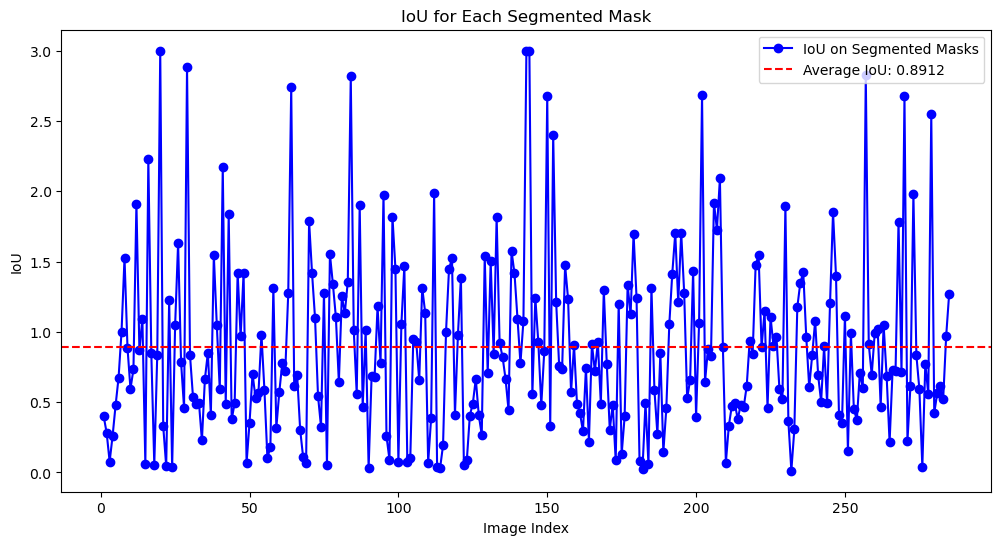

In [29]:
# Graficar IoU de cada máscara segmentada
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(segmented_iou_scores) + 1), segmented_iou_scores, 'bo-', label='IoU on Segmented Masks')
plt.axhline(y=average_iou_segmented, color='r', linestyle='--', label=f'Average IoU: {average_iou_segmented:.4f}')
plt.title('IoU for Each Segmented Mask')
plt.xlabel('Image Index')
plt.ylabel('IoU')
plt.legend()
plt.show()

## Visualizacion de las mascaras generadas por Samgeo

1/1 [==============================] - 0s 25ms/step


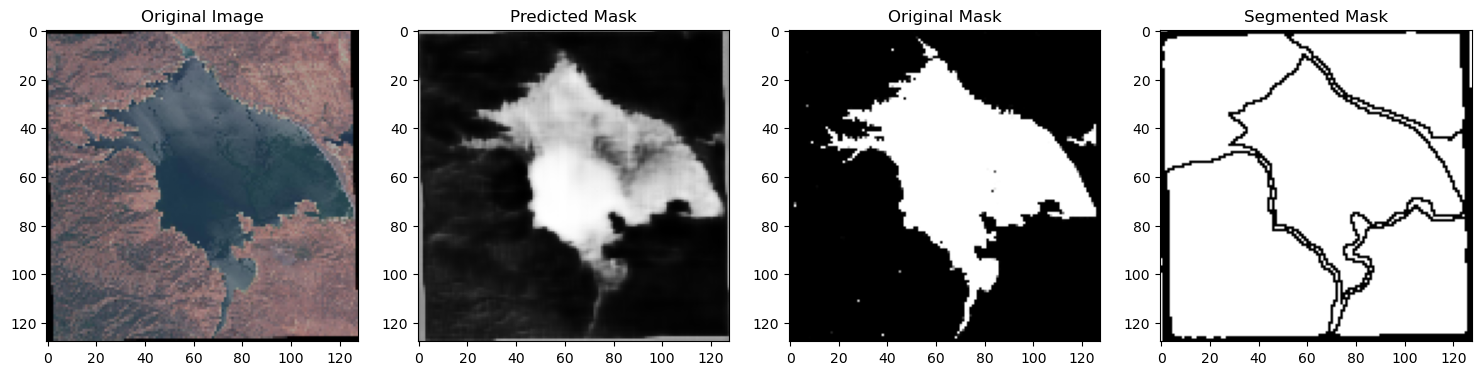

1/1 [==============================] - 0s 26ms/step


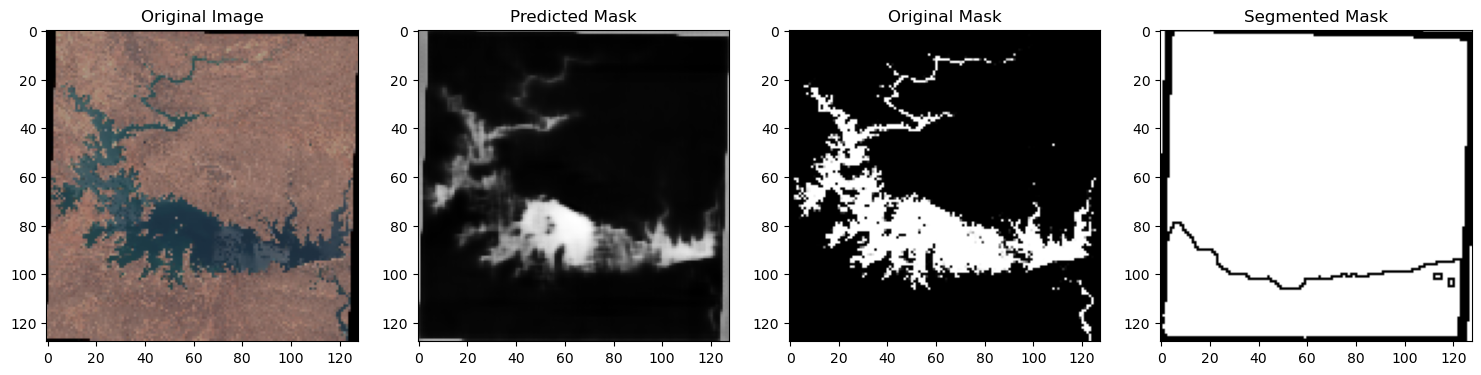

1/1 [==============================] - 0s 25ms/step


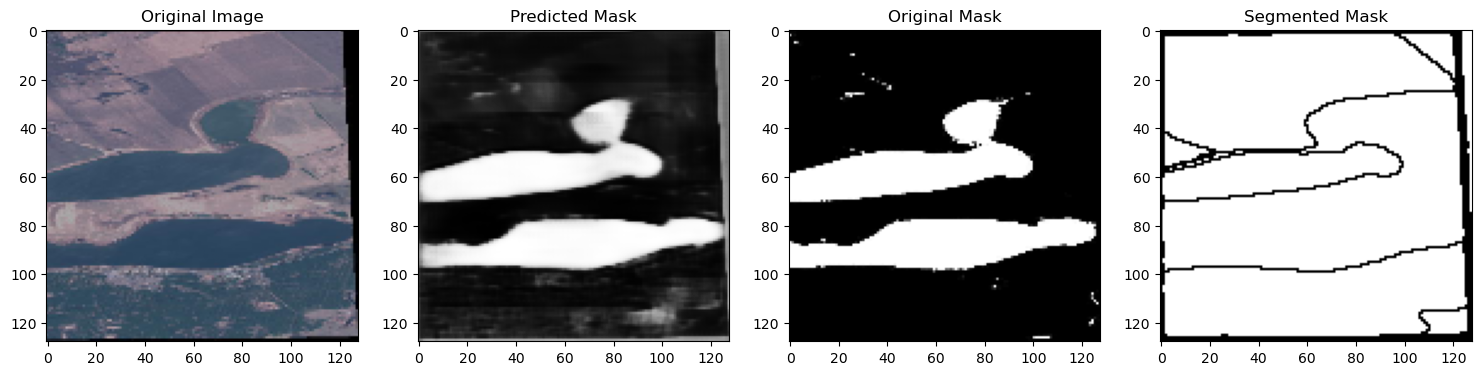

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Función para imprimir tres ejemplos aleatorios con SAM
def print_random_examples_with_sam(model, images, masks, segmented_masks, num_examples=3):
    random_indices = np.random.choice(len(images), num_examples, replace=False)
    for i in random_indices:
        real_img = images[i][np.newaxis, ...]
        pred_mask = model.predict(real_img).reshape(128, 128)
        mask = masks[i].reshape(128, 128)
        segmented_mask = segmented_masks[i]

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 4, 1)
        plt.title("Original Image")
        plt.imshow(real_img[0])

        plt.subplot(1, 4, 2)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')

        plt.subplot(1, 4, 3)
        plt.title("Original Mask")
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 4, 4)
        plt.title("Segmented Mask")
        plt.imshow(segmented_mask, cmap='gray')

        plt.tight_layout()
        plt.show()

# Mostrar ejemplos aleatorios
print_random_examples_with_sam(unet_loaded, X_test, y_test, segmented_masks, num_examples=3)

# Evaluacion de Metricas IoU de Unet vs SAM

C:\Users\JUANC\AppData\Local\Temp\ipykernel_20444\200771187.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['UNet', 'SAMGEO'])


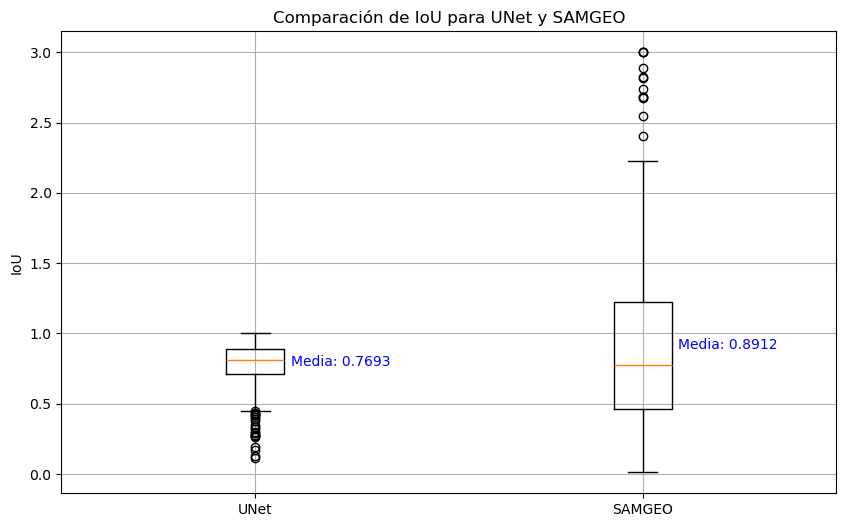

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Crear el gráfico de bigotes
data = [test_iou_scores, segmented_iou_scores]

# Calcular las métricas estadísticas
mean_iou_unet = np.mean(test_iou_scores)
mean_iou_samgeo = np.mean(segmented_iou_scores)

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=['UNet', 'SAMGEO'])
plt.title('Comparación de IoU para UNet y SAMGEO')
plt.ylabel('IoU')
plt.grid(True)

# Añadir las medias al gráfico, posicionadas a un costado de las cajas de bigotes
plt.text(1.22, mean_iou_unet, f'Media: {mean_iou_unet:.4f}', horizontalalignment='center', color='blue')
plt.text(2.22, mean_iou_samgeo, f'Media: {mean_iou_samgeo:.4f}', horizontalalignment='center', color='blue')

# Mostrar el gráfico
plt.show()


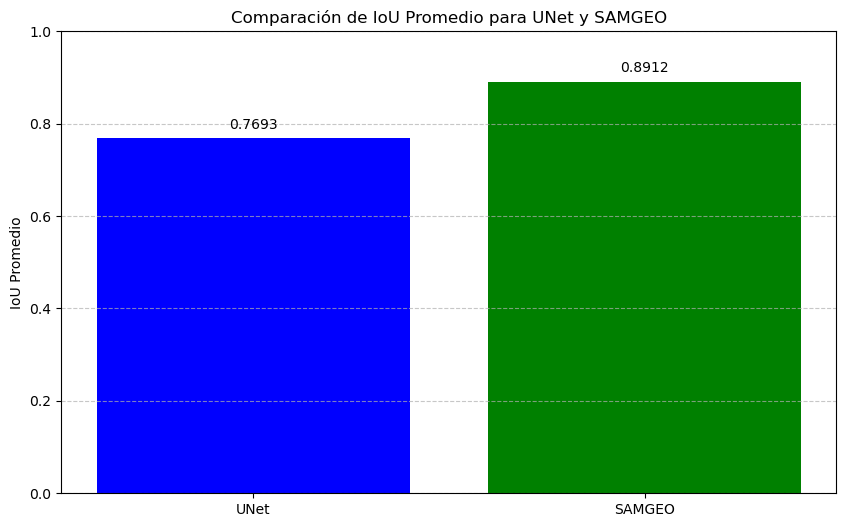

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Crear el gráfico de barras
labels = ['UNet', 'SAMGEO']
means = [mean_iou_unet, mean_iou_samgeo]

plt.figure(figsize=(10, 6))
plt.bar(labels, means, color=['blue', 'green'])
plt.title('Comparación de IoU Promedio para UNet y SAMGEO')
plt.ylabel('IoU Promedio')
plt.ylim(0, 1)
for i, v in enumerate(means):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', color='black')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


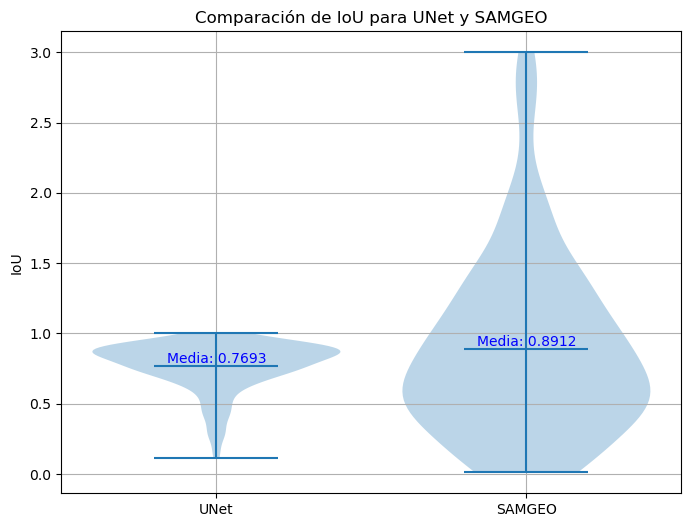

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=True, widths=0.8)
plt.xticks([1, 2], ['UNet', 'SAMGEO'])
plt.title('Comparación de IoU para UNet y SAMGEO')
plt.ylabel('IoU')
plt.grid(True)

# Añadir las medias al gráfico
#plt.text(1, mean_iou_unet + 0.02, f'Media: {mean_iou_unet:.4f}', horizontalalignment='center', color='blue')
#plt.text(2, mean_iou_samgeo + 0.02, f'Media: {mean_iou_samgeo:.4f}', horizontalalignment='center', color='blue')

# Añadir las medias al gráfico, posicionadas encima de la línea de media
for i, mean in enumerate([mean_iou_unet, mean_iou_samgeo], start=1):
    plt.text(i, mean, f'Media: {mean:.4f}', horizontalalignment='center', color='blue', verticalalignment='bottom')

# Ajustar la escala del eje horizontal para que se junten más
plt.xlim(0.5, 2.5)

# Mostrar el gráfico
plt.show()
